### Human in the Loop in LangGraph

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

In [ ]:
!pip install -U langchain-tavily

In [ ]:
#Loading all environment variables
from google.colab import userdata
groq_api_key = userdata.get("GROQ_API_KEY")
langsmith = userdata.get("LANGSMITH_API_KEY")
tavily_api_key = userdata.get("TAVILY_API_KEY")

In [ ]:
#Importing required libraries
from langchain_tavily import TavilySearch
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from typing import List, TypedDict
from typing_extensions import Annotated
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
import os

In [ ]:
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReActAgentdemo"

In [ ]:
#Create a stategraph
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [ ]:
#Create a tools
@tool
def human_assistance(query:str) -> str:
  """ Request assistance from a human."""
  human_response = interrupt({"query": query})
  return human_response["data"]

In [ ]:
tavily_tool = TavilySearch(max_results=2, tavily_api_key = tavily_api_key)

In [ ]:
tools = [tavily_tool, human_assistance]

In [ ]:
#Define LLM model
llm = ChatGroq(model = "openai/gpt-oss-20b", api_key = groq_api_key)

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot(state):
  message = llm_with_tools.invoke(state["messages"])
  # Because we will be interrupting during tool execution,
  # we disable parallel tool calling to avoid repeating any
  # tool invocations when we resume.

  return {"messages": [message]}

In [ ]:
#Build the graph
workflow = StateGraph(State)
#add node
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", ToolNode(tools))
#add edges
workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
)
workflow.add_edge("tools", "chatbot")
#Create a memory
memory = InMemorySaver()
#Compile the graph
graph = workflow.compile(checkpointer= memory)

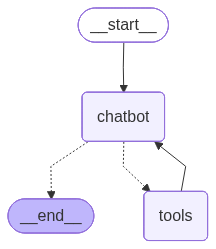

In [ ]:
#Visualize the graph
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (fc_88727a09-31b5-45d9-870f-e2611bd669df)
 Call ID: fc_88727a09-31b5-45d9-870f-e2611bd669df
  Args:
    query: I need some expert guidance and assistance for building an AI agent.


In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (fc_88727a09-31b5-45d9-870f-e2611bd669df)
 Call ID: fc_88727a09-31b5-45d9-870f-e2611bd669df
  Args:
    query: I need some expert guidance and assistance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Absolutely! I’ve reached out to the experts on your behalf. They recommend exploring **LangGraph** for building robust AI agents—it’s designed to be more reliable and extensible than many simple autonomous‑agent frameworks. If you’d like a deeper dive into LangGraph, or help setting up an example, just let me know!
